**_Adventures in Data_: Homicide** <br>
**Chapter 1: Managing Multiple Data Sources**

# Version requirements

The project requires Python > 3.7 as well as 1.0.1 < Scikit-Learn < 3.0.0.

Using the latest version of Scikit-Learn (3.0.1) casues issues with the fitting of the categorical naive Bayes classifier in Chapter 2. Specifically, all the code was executed using Scikit-Learn 1.2.2.

It also makes use of the [Intel Extension for Scikit-Learn](https://intel.github.io/scikit-learn-intelex/latest/), which accelerates existing Scikit-Learn code on platforms using Intel processors.

# Introduction

Societies around the world have a vested interest in justice: people want to see those who harm others punished. Yet, criminal investigation is by no means a certain venture.

When a crime is detected and a case opened, there is no guarantee that the perpetrator will be caught. But why? What trends exist in homicide cases and what factors contribute to successful closing (or not) of a criminal case?

To investigate this question, I combined two datasets of homicide case data: one compiled by a team at [_The Washington Post_](https://github.com/washingtonpost/data-homicides), covering 52, 000 hommicides in 50 of the largest cities in the United States, from January 1, 2007 to December 31, 2017, and the second, from the [Murder Accountability Project](https://www.murderdata.org/p/data-docs.html), dowloaded September 19, 2023.

# Data provenance

One dataset was compiled by a team at _The Washington Post_ using various sources, complete and partial. cross-reference with FBI data to generate a complete dataset.

The second was compiled by the Murder Accountability Project, using data from official FBI records as well as other sources, using the Freedom of Information Act. The Murder Accountability Project claims to have the most complete repository on US homicide data available anywhere.

# Preliminary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Import data

Originally the _Washington Post_ data was downloaded as a CSV, but importing it as a CSV directly caused issues so I opened it in Excel and saved it in the XLSX format, which imports without issue.

Additionally, the `dtype` argument specifies that the data should be impoprted as the `object` type, which allows for all types of values in all columns.

The data columns will be formatted after some initial investigation.

In [2]:
df_wp = pd.read_excel("./data/homicide-data.xlsx", dtype=object)

In [3]:
df_map = pd.read_csv("./data/murder-accountability-project.csv", dtype=object)

We will also enable an option to see all the columns of a dataframe:

In [191]:
pd.set_option("display.max_columns", None)

# Data quality checks and preprocessing

## _Washington Post_ data

### Data value exploration

In [4]:
df_wp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52179 entries, 0 to 52178
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   uid            52179 non-null  object
 1   reported_date  52179 non-null  object
 2   victim_last    52178 non-null  object
 3   victim_first   52179 non-null  object
 4   victim_race    52179 non-null  object
 5   victim_age     52179 non-null  object
 6   victim_sex     52179 non-null  object
 7   city           52179 non-null  object
 8   state          52179 non-null  object
 9   lat            52119 non-null  object
 10  lon            52119 non-null  object
 11  disposition    52179 non-null  object
dtypes: object(12)
memory usage: 4.8+ MB


Looks like there are just over 52, 000 entries.

A good way to see what values exist in a dataset, especially one that's been imported with the `object` `dtype`, is to examine random data samples. I prefer this to the usual method of calling the `head()` method on the dataframe because it gets a range of values that may not be fully covered in the first few rows of the dataset.

In [5]:
df_wp.sample(10)

,uid,reported_date,victim_last,victim_first,victim_race,victim_age,victim_sex,city,state,lat,lon,disposition
9679,Chi-005739,20120510,VALLEJO,MAX JR,Hispanic,26,Male,Chicago,IL,41.947941,-87.669142,Open/No arrest
24992,Jac-000560,20110711,GRIFFIN,CODY,White,22,Male,Jacksonville,FL,30.316979,-81.845691,Closed by arrest
4996,Bir-000399,20110629,KIMBLE,TYRONE,Black,47,Male,Birmingham,AL,33.511505,-86.850796,Open/No arrest
21333,Hou-002870,20100717,LNU,FNU,Hispanic,Unknown,Male,Houston,TX,29.836113,-95.529725,Open/No arrest
11581,Chi-007641,20160528,WHITMORE,GARVIN,Black,27,Male,Chicago,IL,41.819261,-87.632437,Open/No arrest
19904,Fre-000145,20100425,SELLERS,ANTHONY,Black,16,Male,Fresno,CA,36.714122,-119.789647,Closed without arrest
40176,Phi-000128,20160120,ADAMS,KHALILAH,Black,36,Female,Philadelphia,PA,39.96579,-75.228452,Closed by arrest
51165,Was-000344,20130912,HENDRIX,DELONTA,Black,32,Male,Washington,DC,38.90373,-77.005704,Open/No arrest
51070,Was-000243,20140910,HALL,EDWARD,Black,38,Male,Washington,DC,38.830231,-77.005886,Closed by arrest
51273,Was-000459,20121002,HOWARD,DARNELL,Black,36,Male,Washington,DC,38.854841,-76.965708,Closed by arrest


<span style="color: red">Note:</span> It's important not to make the sample size too large or run the `sample()` method too many times if you intend to do any kind of hypothesis testing. Ideally, one would be able to access mutiple datasets from the same source, perform data analysis on one, and use the others for hypothesis testing, to avoid the multiple-comparisons problem. Fortunately, this project will not require any hypothesis testing, so we can get as familiar with the data as we want. We will split it into train and test sections in the future, however, to build and tune machine-learning models.

Conveniently, it looks likely that null values are specified as `Unknown` all throughout the dataset.

### Cleaning and preprocessing

This function was written interatively; I didn't know ahead of time which columns would transform easily into another `dtype`, so it took some trial and error.

Note that it adds some columns, to make analysis easier. For instance, the numeric `date` column is used to derive `month`, `weekday`, and `delta_days` columns.

In [138]:
def transform_wp_dataframe (data):
    
    # Avoid accidentally overriding the original
    df_transformed = data.copy()
    
    df_transformed["reported_date"] = pd.to_datetime(df_transformed["reported_date"].map(lambda d: f"{str(d)[:4]}-{str(d)[4:6]}-{str(d)[-2:]}"))
    max_date = df_transformed["reported_date"].max()
    df_transformed["year"] = df_transformed["reported_date"].dt.year.astype(int)
    df_transformed["month"] = df_transformed["reported_date"].dt.month_name().astype("category")
    df_transformed["weekday"] = df_transformed["reported_date"].dt.day_name().astype("category")
    # How long has it been since the case was opened?
    df_transformed["delta_days"] = ((max_date - df_transformed["reported_date"]).dt.total_seconds() / (60 * 60 * 24)).astype(int)
    
    df_transformed["victim_race"] = df_transformed["victim_race"].astype("category")
    df_transformed["victim_age"] = df_transformed["victim_age"].map(lambda s: np.nan if not str(s).isnumeric() else int(s)).astype(pd.Int8Dtype())
    df_transformed["victim_sex"] = df_transformed["victim_sex"].astype("category")
    df_transformed["city"] = df_transformed["city"].astype("category")
    df_transformed["state"] = df_transformed["state"].astype("category")
    
    df_transformed["lat"] = df_transformed["lat"].astype(float)
    df_transformed["lon"] = df_transformed["lon"].astype(float)
    
    df_transformed["disposition"] = df_transformed["disposition"].astype("category")
    
    return df_transformed

In [16]:
data_wp = transform_wp_dataframe(df_wp)

In [8]:
data_wp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52179 entries, 0 to 52178
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   uid            52179 non-null  object        
 1   reported_date  52179 non-null  datetime64[ns]
 2   victim_last    52178 non-null  object        
 3   victim_first   52179 non-null  object        
 4   victim_race    52179 non-null  category      
 5   victim_age     49180 non-null  Int8          
 6   victim_sex     52179 non-null  category      
 7   city           52179 non-null  category      
 8   state          52179 non-null  category      
 9   lat            52119 non-null  float64       
 10  lon            52119 non-null  float64       
 11  disposition    52179 non-null  category      
 12  year           52179 non-null  int32         
 13  month          52179 non-null  category      
 14  weekday        52179 non-null  category      
 15  delta_days     5217

array([[<Axes: title={'center': 'reported_date'}>,
        <Axes: title={'center': 'victim_age'}>],
       [<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'delta_days'}>]], dtype=object)

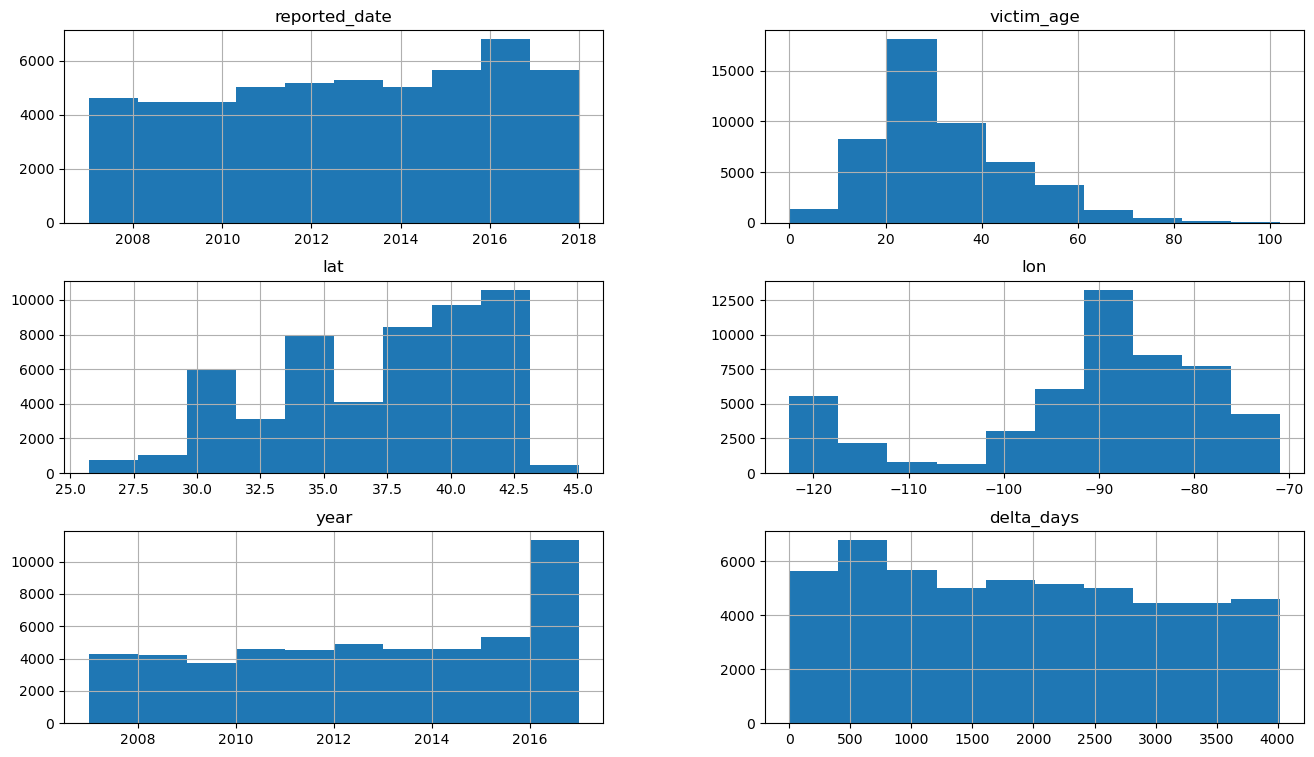

In [105]:
data_wp.hist(figsize=(16, 9))

All seems to be in working order. There are null values, but that's not a problem since we're only analyzing the data and not building any machine learning models (yet). Let's move on to the Murder Accountability Project data.

## Murder Accountability Project Data

### Data value exploration

In [10]:
df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638454 entries, 0 to 638453
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Record ID              638454 non-null  object
 1   Agency Code            638454 non-null  object
 2   Agency Name            638454 non-null  object
 3   Agency Type            638454 non-null  object
 4   City                   638454 non-null  object
 5   State                  638454 non-null  object
 6   Year                   638454 non-null  object
 7   Month                  638454 non-null  object
 8   Incident               638454 non-null  object
 9   Crime Type             638454 non-null  object
 10  Crime Solved           638454 non-null  object
 11  Victim Sex             638454 non-null  object
 12  Victim Age             638454 non-null  object
 13  Victim Race            638454 non-null  object
 14  Victim Ethnicity       638454 non-null  object
 15  

In [192]:
df_map.sample(10)

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
261930,261931,SC02302,Greenville,Municipal Police,Greenville,South Carolina,1992,December,1,Murder or Manslaughter,Yes,Male,43,Black,Unknown,Male,31,Black,Unknown,Unknown,Firearm,0,5,FBI
467509,467510,CA01942,Los Angeles,Municipal Police,Los Angeles,California,2004,March,47,Murder or Manslaughter,Yes,Male,16,Black,Not Hispanic,Male,20,Black,Not Hispanic,Stranger,Handgun,0,0,FBI
612764,612765,CA04908,Petaluma,Municipal Police,Sonoma,California,2012,April,1,Murder or Manslaughter,Yes,Female,43,White,Not Hispanic,Male,41,White,Not Hispanic,Wife,Handgun,0,0,FBI
481706,481707,WI03008,Pleasant Prairie,Municipal Police,Kenosha,Wisconsin,2004,June,1,Murder or Manslaughter,Yes,Male,6,Black,Unknown,Male,45,Black,Unknown,Son,Suffocation,1,0,FBI
571046,571047,LA03701,Monroe,Municipal Police,Ouachita,Louisiana,2010,January,1,Murder or Manslaughter,Yes,Female,38,Black,Unknown,Male,59,Black,Unknown,Wife,Handgun,0,0,FBI
34441,034442,MOSPD00,St. Louis,Municipal Police,St. Louis city,Missouri,1981,January,9,Murder or Manslaughter,No,Male,40,White,Not Hispanic,Unknown,0,Unknown,Unknown,Unknown,Strangulation,0,0,FBI
369016,369017,TNMPD00,Memphis,Municipal Police,Shelby,Tennessee,1997,March,3,Murder or Manslaughter,No,Male,34,Black,Unknown,Unknown,0,Unknown,Unknown,Unknown,Handgun,0,0,FBI
83145,083146,TXHPD00,Houston,Municipal Police,Harris,Texas,1983,August,1,Murder or Manslaughter,Yes,Male,28,White,Hispanic,Male,45,White,Hispanic,Acquaintance,Knife,0,0,FBI
449637,449638,AR06003,North Little Rock,Municipal Police,Pulaski,Arkansas,2003,January,1,Murder or Manslaughter,Yes,Male,48,Black,Unknown,Female,42,Black,Unknown,Acquaintance,Knife,0,0,FBI
448482,448483,VA10300,Chesapeake,Municipal Police,Chesapeake,Virginia,2002,February,2,Murder or Manslaughter,Yes,Male,20,Black,Unknown,Male,17,Black,Unknown,Stranger,Handgun,1,1,FBI


The MAP dataset has more than ten times the number of data points as the _Washington Post_ dataset, and different columns. It does not contain the victim's names, though it does have information about the perpetrators, which the _Post_ dataset does not.

Much like the _Post_ dataset, the MAP dataset specifies unknown categorical values with the `Unknown` value. Unknown numerical data, however, are recorded differently.

### Cleaning and  preprocessing

Cleaning the MAP data was not as straightforward as cleaning the _Post_ data, so I decided to show more of the process of building its transformation function.

The `State` column lists the full name of the state rather than the two-letter abbreviation as the _Post_ data does, so I created this dictionary to make conversion easier (again, this was an iterative process, and I modified code as I encountered and fixed errors and warnings):

In [12]:
state_abbreviations = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AK",
    "American Samoa": "AS",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Guam": "GU",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Northern Mariana Islands": "MP",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Puerto Rico": "PR",
    "Rhode Island": "RI",
    "Rhodes Island": "RI",  # There is a "Rhodes Island" entry in the dataframe
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Trust Territories": "TT",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

<span style="color: red;">Note:</span> This is _not_ the final transformation function.

In [125]:
def transform_map_dataframe_0 (data):
    
    # Avoid accidentally overriding the original
    df_transformed = data.copy()
    
    df_transformed["Record ID"] = data["Record ID"].astype(int)
    
    df_transformed["Agency Code"] = data["Agency Code"].astype("category")
    df_transformed["Agency Name"] = data["Agency Name"].astype("category")
    df_transformed["Agency Type"] = data["Agency Type"].astype("category")
    
    df_transformed["City"] = data["City"].astype("category")
    df_transformed["State"] = data["State"].map(lambda s: state_abbreviations[s]).astype("category")
    
    df_transformed["Year"] = data["Year"].astype(int)
    df_transformed["Month"] = data["Month"].astype("category")
    
    df_transformed["Incident"] = data["Incident"].astype(int)
    df_transformed["Crime Type"] = data["Crime Type"].astype("category")
    df_transformed["Crime Solved"] = data["Crime Solved"].map(lambda s: True if s == "Yes" else False).astype(bool)
    
    df_transformed["Victim Sex"] = data["Victim Sex"].astype("category")
    # According to the MAP docs, an age value of 998 indicates an unknown age
    df_transformed["Victim Age"] = data["Victim Age"].map(lambda s: np.nan if not s.isnumeric() or int(s) > 900 else int(s)).astype(pd.Int8Dtype())
    df_transformed["Victim Race"] = data["Victim Race"].astype("category")
    df_transformed["Victim Ethnicity"] = data["Victim Ethnicity"].astype("category")
    
    df_transformed["Perpetrator Sex"] = data["Perpetrator Sex"].astype("category")
    # According to the MAP docs, an age value of 998 indicates an unknown age
    df_transformed["Perpetrator Age"] = data["Perpetrator Age"].map(lambda s: np.nan if not s.isnumeric() or int(s) > 900 else int(s)).astype(pd.Int8Dtype())
    df_transformed["Perpetrator Race"] = data["Perpetrator Race"].astype("category")
    df_transformed["Perpetrator Ethnicity"] = data["Perpetrator Ethnicity"].astype("category")
    
    df_transformed["Relationship"] = data["Relationship"].astype("category")
    df_transformed["Weapon"] = data["Weapon"].astype("category")
    
    df_transformed["Victim Count"] = data["Victim Count"].astype(int)
    df_transformed["Perpetrator Count"] = data["Perpetrator Count"].astype("category")
    
    df_transformed["Record Source"] = data["Record Source"].astype("category")
    
    return df_transformed

In [126]:
data_map_0 = transform_map_dataframe_0(df_map)

In [127]:
data_map_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638454 entries, 0 to 638453
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   Record ID              638454 non-null  int32   
 1   Agency Code            638454 non-null  category
 2   Agency Name            638454 non-null  category
 3   Agency Type            638454 non-null  category
 4   City                   638454 non-null  category
 5   State                  638454 non-null  category
 6   Year                   638454 non-null  int32   
 7   Month                  638454 non-null  category
 8   Incident               638454 non-null  int32   
 9   Crime Type             638454 non-null  category
 10  Crime Solved           638454 non-null  bool    
 11  Victim Sex             638454 non-null  category
 12  Victim Age             637480 non-null  Int8    
 13  Victim Race            638454 non-null  category
 14  Victim Ethnicity    

array([[<Axes: title={'center': 'Record ID'}>,
        <Axes: title={'center': 'Year'}>],
       [<Axes: title={'center': 'Incident'}>,
        <Axes: title={'center': 'Victim Age'}>],
       [<Axes: title={'center': 'Perpetrator Age'}>,
        <Axes: title={'center': 'Victim Count'}>]], dtype=object)

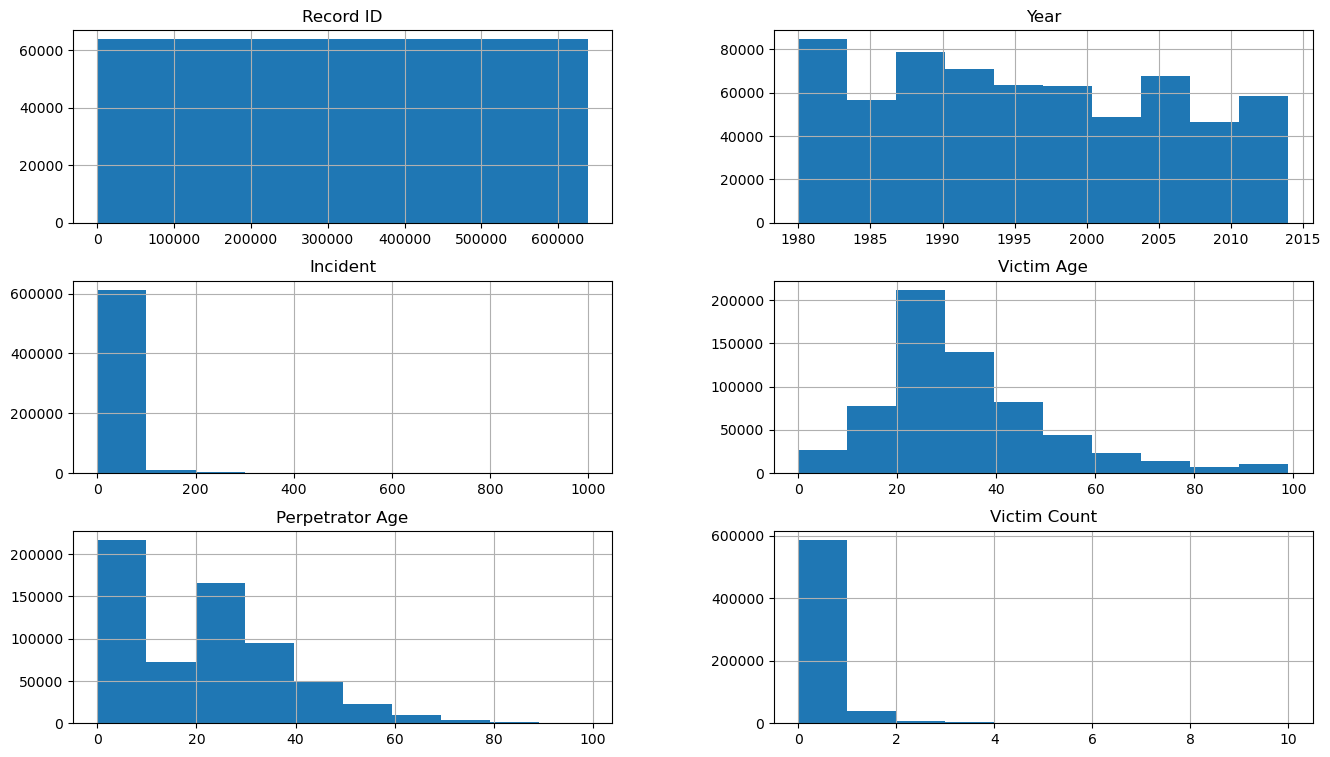

In [128]:
data_map_0.hist(figsize=(16, 9))

Everything seems to be in order, except for the `Perpetrator Age` column: there's no way children are committing more homicides than adults. This is strange, because according to the [MAP data dictionary](https://www.dropbox.com/s/lo6tgo8nnbpqeru/MAPdefinitionsSHR.pdf?dl=1), unknown age values should all be encoded by the number `998`, yet it seems that `0` is used as a placeholder as well:

<Axes: >

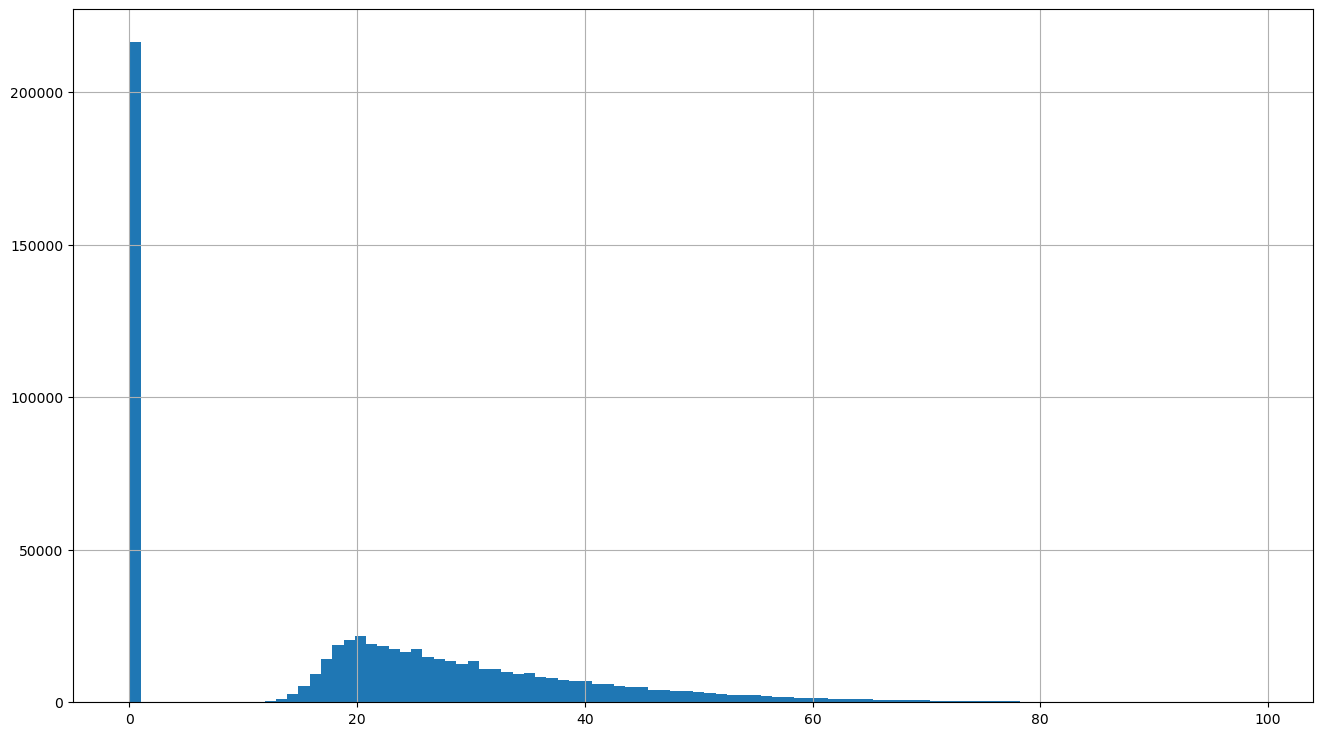

In [129]:
data_map_0["Perpetrator Age"].hist(bins = 100, figsize=(16, 9))

My instinct was initially to add a clause to the `transform_map_dataframe()` function to convert `Perpetrator Age` values of `0` to `np.nan`s, but there may be cases where, for instance, a newborn mishandled a firearm and caused death, or some other actually representative data that I don't want to destroy.

In hopes of finding a better way of handling this discrepancy, I looked at how many data points have small `Perpetrator Age` values:

In [142]:
data_map_0["Perpetrator Age"].value_counts().sort_index()[:19]

Perpetrator Age
0     216327
1         34
2          6
3         24
4         29
5         33
6         50
7         48
8         62
9         86
10       145
11       227
12       487
13      1109
14      2567
15      5441
16      9423
17     14196
18     18834
Name: count, dtype: Int64

216,327, or about a third, of all cases have `Perpetrator Age` recorded as `0`, which dramatically reduces the usefulness of the `Perpetrator Age` column. That is discouraging, because it means we will likely have to replace all `0`s in the `Perpatrator Age` column with `np.nan`.

It strikes me as extremely unlikely that newborns and one-year-olds cause more death than two-, three-, four-, or five-year-olds. I could find no reference to `0` being used as a placeholder, but it seems to be the only possible explanation for such data.

Given the big jump between the number of cases with a `Perpetrator Age` of `9` and `10`, let's focus on cases with perpetrators recorded as being younger than 10 and see what they have in common:

In [143]:
young_perps = data_map_0[data_map_0["Perpetrator Age"] < 10].copy()

In [144]:
young_perps[["Perpetrator Sex"]].value_counts()

Perpetrator Sex
Unknown            189764
Male                25885
Female               1050
Name: count, dtype: int64

In [145]:
young_perps[["Perpetrator Race"]].value_counts()

Perpetrator Race             
Unknown                          192528
Black                             16407
White                              7467
Asian/Pacific Islander              213
Native American/Alaska Native        84
Name: count, dtype: int64

In [146]:
young_perps[["Perpetrator Ethnicity"]].value_counts()

Perpetrator Ethnicity
Unknown                  207930
Not Hispanic               6233
Hispanic                   2536
Name: count, dtype: int64

In [147]:
young_perps[["Relationship"]].value_counts()

Relationship        
Unknown                 192011
Stranger                 16012
Acquaintance              5641
Friend                     569
Wife                       336
Girlfriend                 286
Family                     269
Son                        244
Daughter                   197
Brother                    176
Husband                    155
Boyfriend/Girlfriend       125
Boyfriend                  119
Neighbor                   102
Sister                      99
Mother                      74
Father                      68
Common-Law Wife             56
In-Law                      41
Common-Law Husband          36
Ex-Wife                     32
Stepfather                  15
Stepson                     10
Ex-Husband                   7
Employee                     7
Employer                     6
Stepdaughter                 4
Stepmother                   2
Name: count, dtype: int64

In [148]:
young_perps[["Crime Type"]].value_counts()

Crime Type                
Murder or Manslaughter        215993
Manslaughter by Negligence       706
Name: count, dtype: int64

In each of these, there are more `Unknown`s than every other value combined. That makes sense; if the perpetrator's age is unknown, then they presumably haven't been caught, which means one or more other characteristics of the perpetrator are likely to be unknown as well.

In any case, the final MAP data cleaning function replaces all `0`s in the `Perpetrator Age` column with `np.nan`s, because I could think of no better way to handle this discrepancy at the time (though this may be a good use case for machine learning: can we predict the real perpetrator age based on other information about the perpetrator and the crime?):

In [130]:
def transform_map_dataframe (data):
    
    # Avoid accidentally overriding the original
    df_transformed = data.copy()
    
    df_transformed["Record ID"] = data["Record ID"].astype(int)
    
    df_transformed["Agency Code"] = data["Agency Code"].astype("category")
    df_transformed["Agency Name"] = data["Agency Name"].astype("category")
    df_transformed["Agency Type"] = data["Agency Type"].astype("category")
    
    df_transformed["City"] = data["City"].astype("category")
    df_transformed["State"] = data["State"].map(lambda s: state_abbreviations[s]).astype("category")
    
    df_transformed["Year"] = data["Year"].astype(int)
    df_transformed["Month"] = data["Month"].astype("category")
    
    df_transformed["Incident"] = data["Incident"].astype(int)
    df_transformed["Crime Type"] = data["Crime Type"].astype("category")
    df_transformed["Crime Solved"] = data["Crime Solved"].map(lambda s: True if s == "Yes" else False).astype(bool)
    
    df_transformed["Victim Sex"] = data["Victim Sex"].astype("category")
    # According to the MAP docs, an age value of 998 indicates an unknown age
    df_transformed["Victim Age"] = data["Victim Age"].map(lambda s: np.nan if not s.isnumeric() or int(s) > 900 else int(s)).astype(pd.Int8Dtype())
    df_transformed["Victim Race"] = data["Victim Race"].astype("category")
    df_transformed["Victim Ethnicity"] = data["Victim Ethnicity"].astype("category")
    
    df_transformed["Perpetrator Sex"] = data["Perpetrator Sex"].astype("category")
    # According to the MAP docs, an age value of 998 indicates an unknown age;
    # However, a look at the data indicates that 0 is used as a placeholder as well.
    df_transformed["Perpetrator Age"] = data["Perpetrator Age"].map(lambda s: np.nan if not s.isnumeric() or int(s) > 900 or int(s) == 0 else int(s)).astype(pd.Int8Dtype())
    df_transformed["Perpetrator Race"] = data["Perpetrator Race"].astype("category")
    df_transformed["Perpetrator Ethnicity"] = data["Perpetrator Ethnicity"].astype("category")
    
    df_transformed["Relationship"] = data["Relationship"].astype("category")
    df_transformed["Weapon"] = data["Weapon"].astype("category")
    
    df_transformed["Victim Count"] = data["Victim Count"].astype(int)
    df_transformed["Perpetrator Count"] = data["Perpetrator Count"].astype("category")
    
    df_transformed["Record Source"] = data["Record Source"].astype("category")
    
    return df_transformed

In [131]:
data_map = transform_map_dataframe(df_map)

In [132]:
data_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638454 entries, 0 to 638453
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   Record ID              638454 non-null  int32   
 1   Agency Code            638454 non-null  category
 2   Agency Name            638454 non-null  category
 3   Agency Type            638454 non-null  category
 4   City                   638454 non-null  category
 5   State                  638454 non-null  category
 6   Year                   638454 non-null  int32   
 7   Month                  638454 non-null  category
 8   Incident               638454 non-null  int32   
 9   Crime Type             638454 non-null  category
 10  Crime Solved           638454 non-null  bool    
 11  Victim Sex             638454 non-null  category
 12  Victim Age             637480 non-null  Int8    
 13  Victim Race            638454 non-null  category
 14  Victim Ethnicity    

Only around two thirds of the `Perpetrator Age` column is now non-null. But, the data is now more representative of the known information, which is more useful than non-null but misrepresentative data. Let's check out the histograms of the transformed data:

array([[<Axes: title={'center': 'Record ID'}>,
        <Axes: title={'center': 'Year'}>],
       [<Axes: title={'center': 'Incident'}>,
        <Axes: title={'center': 'Victim Age'}>],
       [<Axes: title={'center': 'Perpetrator Age'}>,
        <Axes: title={'center': 'Victim Count'}>]], dtype=object)

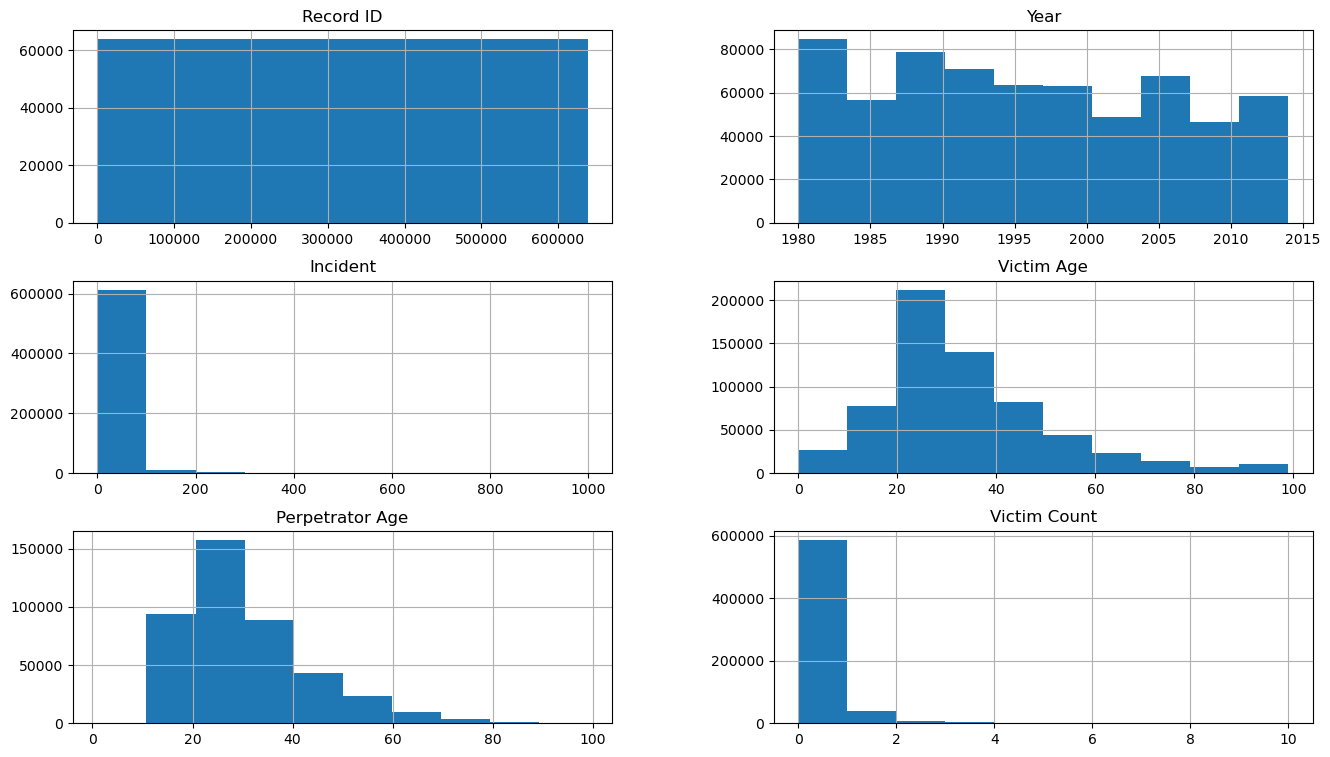

In [161]:
data_map.hist(figsize=(16, 9))

The `Perpetrator Age` data are now much more realistically distributed. Let's look at them in more detail:

<Axes: >

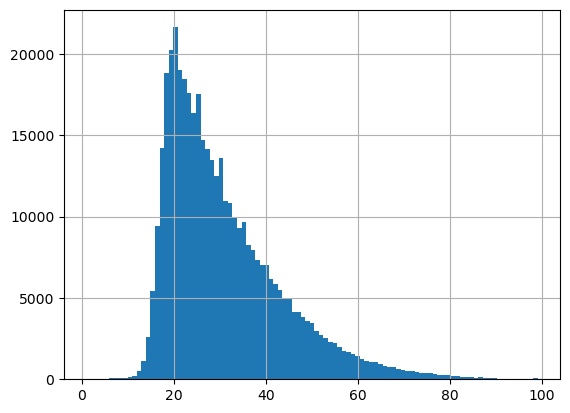

In [162]:
data_map["Perpetrator Age"].hist(bins=99)

Marvelous. We can see spikes at age values that are multiples of 5, probably occuring due to age estimates being rounded (e.g. "he was about 45 years old").

Much like the victims' ages, the perpetrators' ages are right-skewed.

Finally, there is a slight bump at the value `99`; according to the MAP data dictionary, a value of `99` represents the age being `99` _or older_. Normally this would be inconvenient, because that would give the data a categorical-like property, but in this case the number of data points with a `Perpetrator Age` of `99` is so small on the large scale that the bump in the distribution's tail can be put down to noise.

On the small scale, though, that "bump" becomes a skyscraper:

<Axes: >

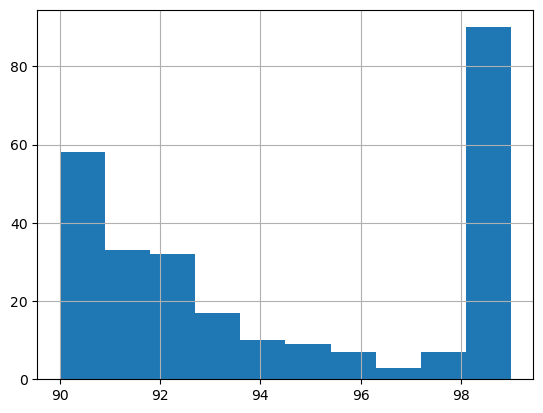

In [163]:
data_map["Perpetrator Age"][data_map["Perpetrator Age"] >= 90].hist(bins = 10)

If we were focusing on perpetrators 90 years old or older, this would be a big problem.

# Difficulty in combining the datasets

Both the _Washington Post_ data and the Murder Accountability Project data have been analyzed quite thoroughly. I want to combine these datasets, using the specific information in the _Post_ dataset to find the corresponding case in the MAP dataset and join the columns.

The problem, of course, is that the MAP dataset does not have a column for the report date. Additionally, the `Year` and `Month` columns, according to the MAP data dictionary, represent the year and month of the homicide or when the body was recovered, rather than the year and month of the report, as in the _Post_ dataset.

Also, just because a characteristic (e.g. age, sex, etc.) is recorded in one dataset does not mean it will be recorded in the other.

Finally, despite the MAP dataset being rather comprehensive, there isn't even any guarantee that a case in the _Post_ dataset exists in the MAP dataset.

This means that there may be multiple or no MAP data points corresponding to each _Post_ data point, and so we can't just run a `pandas.merge()` on the two dataframes and assume it will work.

Let's start by checking out the columns of each dataset and see which ones we can use to merge on:

In [164]:
print(data_wp.columns)
print(data_map.columns)

Index(['uid', 'reported_date', 'victim_last', 'victim_first', 'victim_race',
       'victim_age', 'victim_sex', 'city', 'state', 'lat', 'lon',
       'disposition', 'year', 'month', 'weekday', 'delta_days'],
      dtype='object')
Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')


Obviously, the city and state are the first filters we will apply to narrow things down.

After that, the year and month will narrow our time range.

Finally, information about the victim, including age, sex, and race should give us the exact case in the MAP data.

I suspect that data about the victim, as well as the year and month, are the most likely to be inconsistent in the two datasets, and geographic information most likely to be the same.

My reasoning is that information about the victim might not be known at the time the record was made by the agency from which the data was extracted in one dataset, but may have been known when the other dataset was compiled.

Additionally, the _Post_ dataset and MAP dataset use dates differently: the _Post_ dataset records the date the crime was reported, whereas the MAP dataset records the date _of the homicide or recovery of the body_. Those are not always the same.

You see, I hope, the challenge ahead.

For now, let's write a function that performs a simple inner-join on the two datasets based on all of the discussed factors, just to see what we get:

In [200]:
def simple_merge():

    map_cols = [ "City", "State", "Year", "Month", "Victim Sex", "Victim Race", "Victim Age" ]
    wp_cols = [ "city", "state", "year", "month", "victim_sex", "victim_race", "victim_age" ]
    
    df_filtered = pd.merge(data_wp, data_map, left_on=wp_cols, right_on=map_cols)
    
    return df_filtered

In [201]:
data_simple_merged = simple_merge()

In [202]:
data_simple_merged

,uid,reported_date,victim_last,victim_first,victim_race,victim_age,victim_sex,city,state,lat,lon,disposition,year,month,weekday,delta_days,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,Bal-001607,2007-01-01,NELSON,LEON,Black,17,Male,Baltimore,MD,39.310903,-76.675310,Open/No arrest,2007,January,Monday,4017,524233,MD00301,Baltimore County,County Police,Baltimore,MD,2007,January,3,Murder or Manslaughter,False,Male,17,Black,Unknown,Unknown,<NA>,Unknown,Unknown,Unknown,Handgun,0,0,FBI
1,Bal-001680,2007-04-09,DAUGHTRY,JOHN,Black,25,Male,Baltimore,MD,39.285132,-76.676047,Open/No arrest,2007,April,Monday,3919,524243,MD00301,Baltimore County,County Police,Baltimore,MD,2007,April,3,Murder or Manslaughter,False,Male,25,Black,Unknown,Unknown,<NA>,Unknown,Unknown,Unknown,Handgun,1,0,FBI
2,Bal-001683,2007-04-18,JAMES,JONNIE ANTHONY,Black,25,Male,Baltimore,MD,39.283287,-76.652856,Closed by arrest,2007,April,Wednesday,3910,524243,MD00301,Baltimore County,County Police,Baltimore,MD,2007,April,3,Murder or Manslaughter,False,Male,25,Black,Unknown,Unknown,<NA>,Unknown,Unknown,Unknown,Handgun,1,0,FBI
3,Bal-001689,2007-04-27,SMITH,DEWITT,Black,25,Male,Baltimore,MD,39.306178,-76.669353,Closed by arrest,2007,April,Friday,3901,524243,MD00301,Baltimore County,County Police,Baltimore,MD,2007,April,3,Murder or Manslaughter,False,Male,25,Black,Unknown,Unknown,<NA>,Unknown,Unknown,Unknown,Handgun,1,0,FBI
4,Bal-001696,2007-04-30,QUEEN,ERIC,Black,24,Male,Baltimore,MD,39.310901,-76.592825,Closed by arrest,2007,April,Monday,3898,524241,MD00301,Baltimore County,County Police,Baltimore,MD,2007,April,1,Murder or Manslaughter,False,Male,24,Black,Unknown,Unknown,<NA>,Unknown,Unknown,Unknown,Handgun,0,0,FBI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920,Tul-000652,2014-10-26,STRATTON,BEVERLY,White,32,Female,Tulsa,OK,36.219500,-95.985342,Closed by arrest,2014,October,Sunday,1162,634689,OK07205,Tulsa,Municipal Police,Tulsa,OK,2014,October,106,Murder or Manslaughter,True,Female,32,White,Not Hispanic,Male,31,Black,Not Hispanic,Common-Law Wife,Handgun,0,0,FBI
5921,Tul-000655,2014-11-26,DOUGLAS,AMANDA,White,26,Female,Tulsa,OK,36.100169,-95.851061,Closed by arrest,2014,November,Wednesday,1131,634690,OK07205,Tulsa,Municipal Police,Tulsa,OK,2014,November,102,Murder or Manslaughter,True,Female,26,White,Not Hispanic,Male,3,White,Not Hispanic,Mother,Handgun,0,0,FBI
5922,Tul-000655,2014-11-26,DOUGLAS,AMANDA,White,26,Female,Tulsa,OK,36.100169,-95.851061,Closed by arrest,2014,November,Wednesday,1131,634691,OK07205,Tulsa,Municipal Police,Tulsa,OK,2014,November,103,Murder or Manslaughter,False,Female,26,White,Not Hispanic,Unknown,<NA>,Unknown,Unknown,Unknown,Handgun,1,0,FBI
5923,Tul-000656,2014-11-26,SUDAR,JENNIFER,White,37,Female,Tulsa,OK,36.100169,-95.851061,Closed by arrest,2014,November,Wednesday,1131,634645,OK07205,Tulsa,Municipal Police,Tulsa,OK,2014,November,103,Murder or Manslaughter,False,Female,37,White,Not Hispanic,Unknown,<NA>,Unknown,Unknown,Unknown,Handgun,1,0,FBI


Only 5,925 data points, which is about a tenth of the total number of cases in the _Post_ dataset. Additionally, there are some duplicates, indicating that some cases in the _Post_ dataset correspond to multiple cases in the MAP dataset:

In [203]:
data_simple_merged["uid"].duplicated().sum()

1592

In [204]:
len(data_simple_merged["uid"].unique())

4333

In [206]:
data_simple_merged["uid"].value_counts().sort_values(ascending=False)

uid
Phi-001063    7
Phi-004265    7
Phi-004260    7
Phi-001060    7
Phi-001065    7
             ..
SD-000031     1
SD-000032     1
SD-000033     1
SD-000034     1
Tul-000658    1
Name: count, Length: 4333, dtype: int64

Of the 5,925 rows in the merged dataset, 4,333 are unique cases in the _Post_ dataset, which means that numerous cases in the _Post_ dataset correspond to more than one case in the MAP dataset, even though we used every possible filter to merge the two.

In particular, let's take a look at the case with `uid` `Tul-000655`:

In [196]:
data_simple_merged[data_simple_merged["uid"] == "Tul-000655"]

,uid,reported_date,victim_last,victim_first,victim_race,victim_age,victim_sex,city,state,lat,lon,disposition,year,month,weekday,delta_days,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
5921,Tul-000655,2014-11-26,DOUGLAS,AMANDA,White,26,Female,Tulsa,OK,36.100169,-95.851061,Closed by arrest,2014,November,Wednesday,1131,634690,OK07205,Tulsa,Municipal Police,Tulsa,OK,2014,November,102,Murder or Manslaughter,True,Female,26,White,Not Hispanic,Male,3,White,Not Hispanic,Mother,Handgun,0,0,FBI
5922,Tul-000655,2014-11-26,DOUGLAS,AMANDA,White,26,Female,Tulsa,OK,36.100169,-95.851061,Closed by arrest,2014,November,Wednesday,1131,634691,OK07205,Tulsa,Municipal Police,Tulsa,OK,2014,November,103,Murder or Manslaughter,False,Female,26,White,Not Hispanic,Unknown,<NA>,Unknown,Unknown,Unknown,Handgun,1,0,FBI


It's easy to see which column came from which DataFrame based on the case of the first letter of the column name and whether or words are separated by spaces or underscores.

Case `Tul-000655` in the _Post_ dataset corresponds to two cases in the MAP dataset, both in November 2014, in which a White, 26 year old woman was killed by a handgun. In one case, the perpetrator was her three-year-old son (presumably accidentally). In the other, the perpetrator is unknown. Without the exact date, we don't have enough information to find an exact match in the MAP data.

An internet search of the name, month, and year, however, [makes clear](https://www.newson6.com/story/5e3625222f69d76f62048443/police:-tulsa-man-charged-with-double-murder-was-hired-killer) that this record corresponds to `Record ID` `634691` in the MAP dataset. However, this case was closed by arrest in 2015 &mdash; which the MAP dataset does not tell us.

An internet search also turns up [the other case](https://www.newson6.com/story/5e3629382f69d76f6204ae65/tulsa-police:-3yearold-accidentally-shot-killed-mother) in the MAP dataset, with `Record ID` `634690`. Interestingly, the MAP data indicates that the homicide occurred on November 26, but it was already in the news on November 24. Another discrepancy.

Let's check out one more `uid`:

In [208]:
data_simple_merged[data_simple_merged["uid"] == "Phi-001063"]

,uid,reported_date,victim_last,victim_first,victim_race,victim_age,victim_sex,city,state,lat,lon,disposition,year,month,weekday,delta_days,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
2352,Phi-001063,2010-09-18,JACKSON,NATHANIEL,Black,21,Male,Philadelphia,PA,40.018105,-75.157853,Closed by arrest,2010,September,Saturday,2661,576786,PAPEP00,Philadelphia,Municipal Police,Philadelphia,PA,2010,September,7,Murder or Manslaughter,True,Male,21,Black,Not Hispanic,Male,<NA>,Black,Not Hispanic,Unknown,Handgun,0,0,FBI
2353,Phi-001063,2010-09-18,JACKSON,NATHANIEL,Black,21,Male,Philadelphia,PA,40.018105,-75.157853,Closed by arrest,2010,September,Saturday,2661,576793,PAPEP00,Philadelphia,Municipal Police,Philadelphia,PA,2010,September,14,Murder or Manslaughter,True,Male,21,Black,Not Hispanic,Male,18,Black,Not Hispanic,Unknown,Handgun,0,0,FBI
2354,Phi-001063,2010-09-18,JACKSON,NATHANIEL,Black,21,Male,Philadelphia,PA,40.018105,-75.157853,Closed by arrest,2010,September,Saturday,2661,576795,PAPEP00,Philadelphia,Municipal Police,Philadelphia,PA,2010,September,16,Murder or Manslaughter,True,Male,21,Black,Not Hispanic,Male,22,Black,Not Hispanic,Unknown,Handgun,0,1,FBI
2355,Phi-001063,2010-09-18,JACKSON,NATHANIEL,Black,21,Male,Philadelphia,PA,40.018105,-75.157853,Closed by arrest,2010,September,Saturday,2661,576797,PAPEP00,Philadelphia,Municipal Police,Philadelphia,PA,2010,September,18,Murder or Manslaughter,True,Male,21,Black,Not Hispanic,Male,19,Black,Not Hispanic,Unknown,Handgun,0,0,FBI
2356,Phi-001063,2010-09-18,JACKSON,NATHANIEL,Black,21,Male,Philadelphia,PA,40.018105,-75.157853,Closed by arrest,2010,September,Saturday,2661,576808,PAPEP00,Philadelphia,Municipal Police,Philadelphia,PA,2010,September,29,Murder or Manslaughter,True,Male,21,Black,Not Hispanic,Male,21,Black,Not Hispanic,Unknown,Handgun,0,0,FBI
2357,Phi-001063,2010-09-18,JACKSON,NATHANIEL,Black,21,Male,Philadelphia,PA,40.018105,-75.157853,Closed by arrest,2010,September,Saturday,2661,576811,PAPEP00,Philadelphia,Municipal Police,Philadelphia,PA,2010,September,32,Murder or Manslaughter,True,Male,21,Black,Not Hispanic,Male,<NA>,Black,Not Hispanic,Unknown,Handgun,0,0,FBI
2358,Phi-001063,2010-09-18,JACKSON,NATHANIEL,Black,21,Male,Philadelphia,PA,40.018105,-75.157853,Closed by arrest,2010,September,Saturday,2661,576813,PAPEP00,Philadelphia,Municipal Police,Philadelphia,PA,2010,September,34,Murder or Manslaughter,True,Male,21,Black,Not Hispanic,Male,29,Black,Not Hispanic,Unknown,Handgun,0,0,FBI


There's absolutely no way to infer which data point in the MAP dataset corresponds to this `uid` based solely on the data.

## References